In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
running_on_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') != 'Localhost'

if running_on_kaggle:
    print('Kaggle environment detected')
    # !nvidia-smi
    data_dir = '/kaggle/input/food41/images/'
else:
    print('Running on localhost')
    data_dir = './dataset/food/images/'
    !pip install --quiet -r requirements.txt
    !python download_data.py

Kaggle environment detected


In [3]:
batch_size = 32

img_height = 224
img_width = 224

In [4]:
train_data_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2)

test_data_generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2)

In [5]:
train_data = train_data_generator.flow_from_directory(
    data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')

val_data = test_data_generator.flow_from_directory(
    data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation')

Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


# ResNet50V2

In [6]:
ResNet50V2 = tf.keras.applications.resnet_v2.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
    classes=101
)

for layer in ResNet50V2.layers:
    layer.trainable = False

2022-03-24 11:15:40.207564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:15:40.290920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:15:40.291586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:15:40.293202: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94683136/94668760 [==============================] - 1s 0us/step


In [7]:
model_ResNet = tf.keras.Sequential([
    ResNet50V2,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(101, activation = 'softmax')
    ])

model_ResNet.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(lr=.0001), 
    metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [8]:
epochs=10
history = model_ResNet.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

2022-03-24 11:15:45.997433: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-03-24 11:15:50.347934: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2525/2525 [==============================] - 1904s 751ms/step - loss: 3.1926 - accuracy: 0.2720 - val_loss: 2.3916 - val_accuracy: 0.4239
Epoch 2/10
2525/2525 [==============================] - 1304s 516ms/step - loss: 2.3954 - accuracy: 0.4215 - val_loss: 2.1302 - val_accuracy: 0.4788
Epoch 3/10
2525/2525 [==============================] - 1343s 532ms/step - loss: 2.2107 - accuracy: 0.4591 - val_loss: 2.0158 - val_accuracy: 0.5016
Epoch 4/10
2525/2525 [==============================] - 1358s 538ms/step - loss: 2.1094 - accuracy: 0.4790 - val_loss: 1.9498 - val_accuracy: 0.5147
Epoch 5/10
2525/2525 [==============================] - 1411s 559ms/step - loss: 2.0392 - accuracy: 0.4941 - val_loss: 1.8959 - val_accuracy: 0.5258
Epoch 6/10
2525/2525 [==============================] - 1407s 557ms/step - loss: 1.9812 - accuracy: 0.5065 - val_loss: 1.8722 - val_accuracy: 0.5337
Epoch 7/10
2525/2525 [==============================] - 1410s 558ms/step - loss: 1.9445 - accuracy: 0.5136 - val_loss

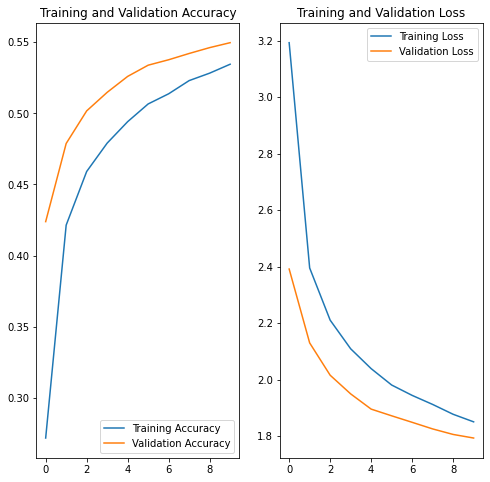

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
model_ResNet.save('/kaggle/working/model')

2022-03-24 15:21:33.892314: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
